# Data Processing

### Introduction
The primary goal of this notebook is to process and analyze geophysical resistivity data. This involves tasks such as importing and processing data, detecting line patterns, and performing advanced data analysis techniques like z-score normalization and Local Outlier Factor (LOF) analysis. To begin, we first need to import the essential libraries that will enable us to handle data, perform computations, and visualize the results effectively.


In [1]:
import csv
import utm
import fiona
import numpy as np
import pandas as pd
import pygimli as pg
import seaborn as sns
import geopandas as gpd
from scipy import interpolate
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from pygimli.frameworks import harmfit
from Data_Processing import LineDetector
from Data_Processing import DataProcessing
from sklearn.ensemble import IsolationForest
from matplotlib.backends.backend_pdf import PdfPages 

### Data Import and Setup
In this section, we define the file paths and names required for the analysis. This includes specifying the location of the resistivity data in CSV format and the reference points in a KML file. These inputs will be used throughout the notebook to process and analyze the resistivity data specific to the `BDW_Seeschlag` farm.

In [5]:
#%% inputs
# Define file paths and names
filepath = 'BDW_Seeschlag_Geophilus_roh_2022-10-20.csv'
farmName = 'BDW_Seeschlag'

# Import reference points from KML file
kmlFile = 'BW45701_Referenzpunkte_gemessen.kml'

### Data Processing Initialization
At this stage, we initialize the data processing by creating an instance of the `DataProcessing` class, which will handle various tasks throughout the analysis. After defining the necessary file paths and names, we proceed to extract the reference point locations from the provided KML file. These reference points are crucial for aligning and interpreting the resistivity data in the context of the specific geographical area of interest.


In [6]:
#%% data processing commands
# Create an instance of DataProcessing
data_processor = DataProcessing()  

# Import reference points from KML file
refPoints = data_processor.import_reference_points_from_kml(kmlFile, farmName)

Reference points saved to BDW_Seeschlag_farm_reference_Points.csv


### Reference Points CSV File
After extracting the reference point locations from the KML file, the data is saved to a CSV file named `BDW_Seeschlag_farm_reference_Points.csv`. This file contains the geographical coordinates of reference points relevant to the `BDW_Seeschlag` farm. The CSV file typically includes columns for point names, easting (E), and northing (N) coordinates in UTM (Universal Transverse Mercator) format.


### Data Preparation and Initial Processing
In this step, we focus on preparing the data for analysis. First, we identify the data points that are nearest to the reference points extracted earlier. 

Next, we define spacing labels, which will be used to categorize the resistivity data based on different measurement spacings or intervals. This helps in organizing and interpreting the data effectively.

Then, we read the original resistivity data from the CSV file into a data structure for further processing. 

In [8]:
# Find nearest points to reference
nearest_points_list, refpoints = data_processor.find_nearest_points_to_reference(filepath, farmName, kmlFile)

# Define spacing labels
spacing_labels = ['Spacing 1', 'Spacing 2', 'Spacing 3', 'Spacing 4', 'Spacing 5']

# Read original data
data = data_processor.read_data(filepath)
downsampled_data = data[::2]

Reference points saved to BDW_Seeschlag_farm_reference_Points.csv
Nearest points indices saved to BDW_Seeschlag_nearest_points_indices.csv


### Line Detection and Visualization
In this part of the process, we perform line detection on the downsampled resistivity data. By analyzing the spatial arrangement of data points, we can identify and group them into lines, which represent linear features or patterns in the dataset. 

To do this, we specify two key parameters:
- `minPoints`: The minimum number of points required to form a line, set to 5 in this case.
- `maxAngleDeviation`: The maximum allowable deviation in angle between consecutive points within a line, set to 31 degrees. This ensures that the detected lines are relatively straight and consistent.

Once the lines are detected and each data point is assigned to a corresponding line, we proceed to visualize these detected lines. The plot generated displays the data points grouped into lines, with reference points overlaid for spatial context. This visualization helps in understanding the structure of the data and assessing the quality of the line detection process.


Number of valid lines detected:  22
Number of invalid lines (containing less than 5 points):  30
Number of detected lines:  22


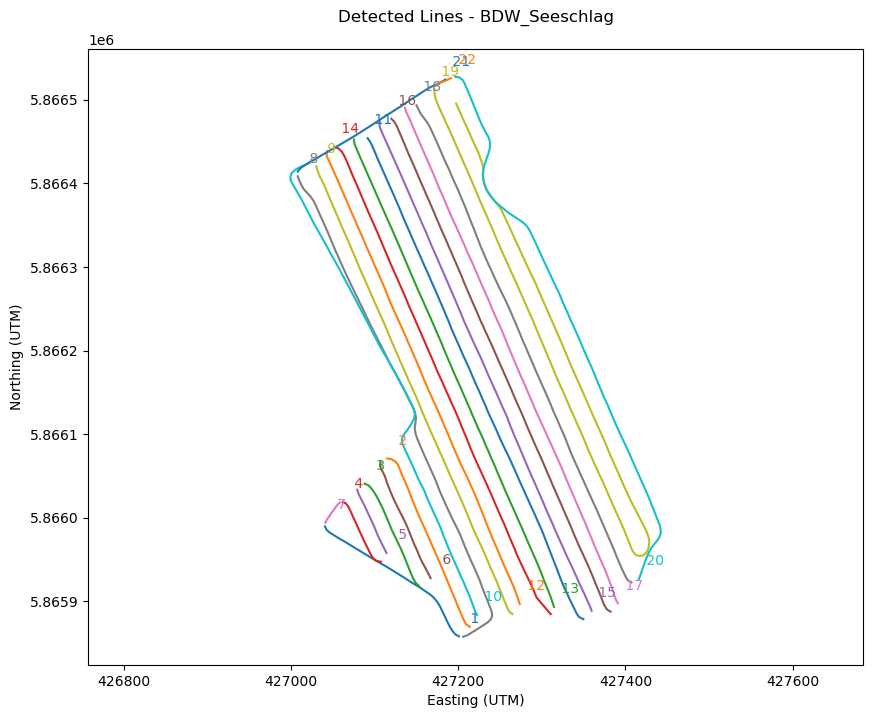

In [9]:
# Line detection and assign one line to each point
minPoints = 5
maxAngleDeviation = 31
data_line_assigned = data_processor.line_detection_and_assign_lines(downsampled_data, farmName, minPoints, maxAngleDeviation)

# Plot detected lines
data_processor.plot_detected_lines(data_line_assigned, farmName, refPoints)

### Areal Plot of Original Data
In this step, we generate an areal plot of the original resistivity data to visualize its spatial distribution across the farm. The plot helps in understanding how the resistivity values vary across the different locations, providing a visual overview of the data.

By plotting the data in a subplot format, we can compare how resistivity values change across different spacings, which is useful for identifying patterns and anomalies in the dataset.

22/08/24 - 14:51:04 - pyGIMLi - INFO - Retrieving file from geodatenzentrum.de using URL: https://sgx.geodatenzentrum.de/wms_dop40__8102b4d5-7fdb-a6a0-d710-890a1caab5c3?service=wms&version=1.3.0&request=GetMap&Layers=rgb&STYLES=default&CRS=EPSG:25833&bbox=426976,5865823,427464,5866561&width=2500&Height=3778&Format=image/jpeg


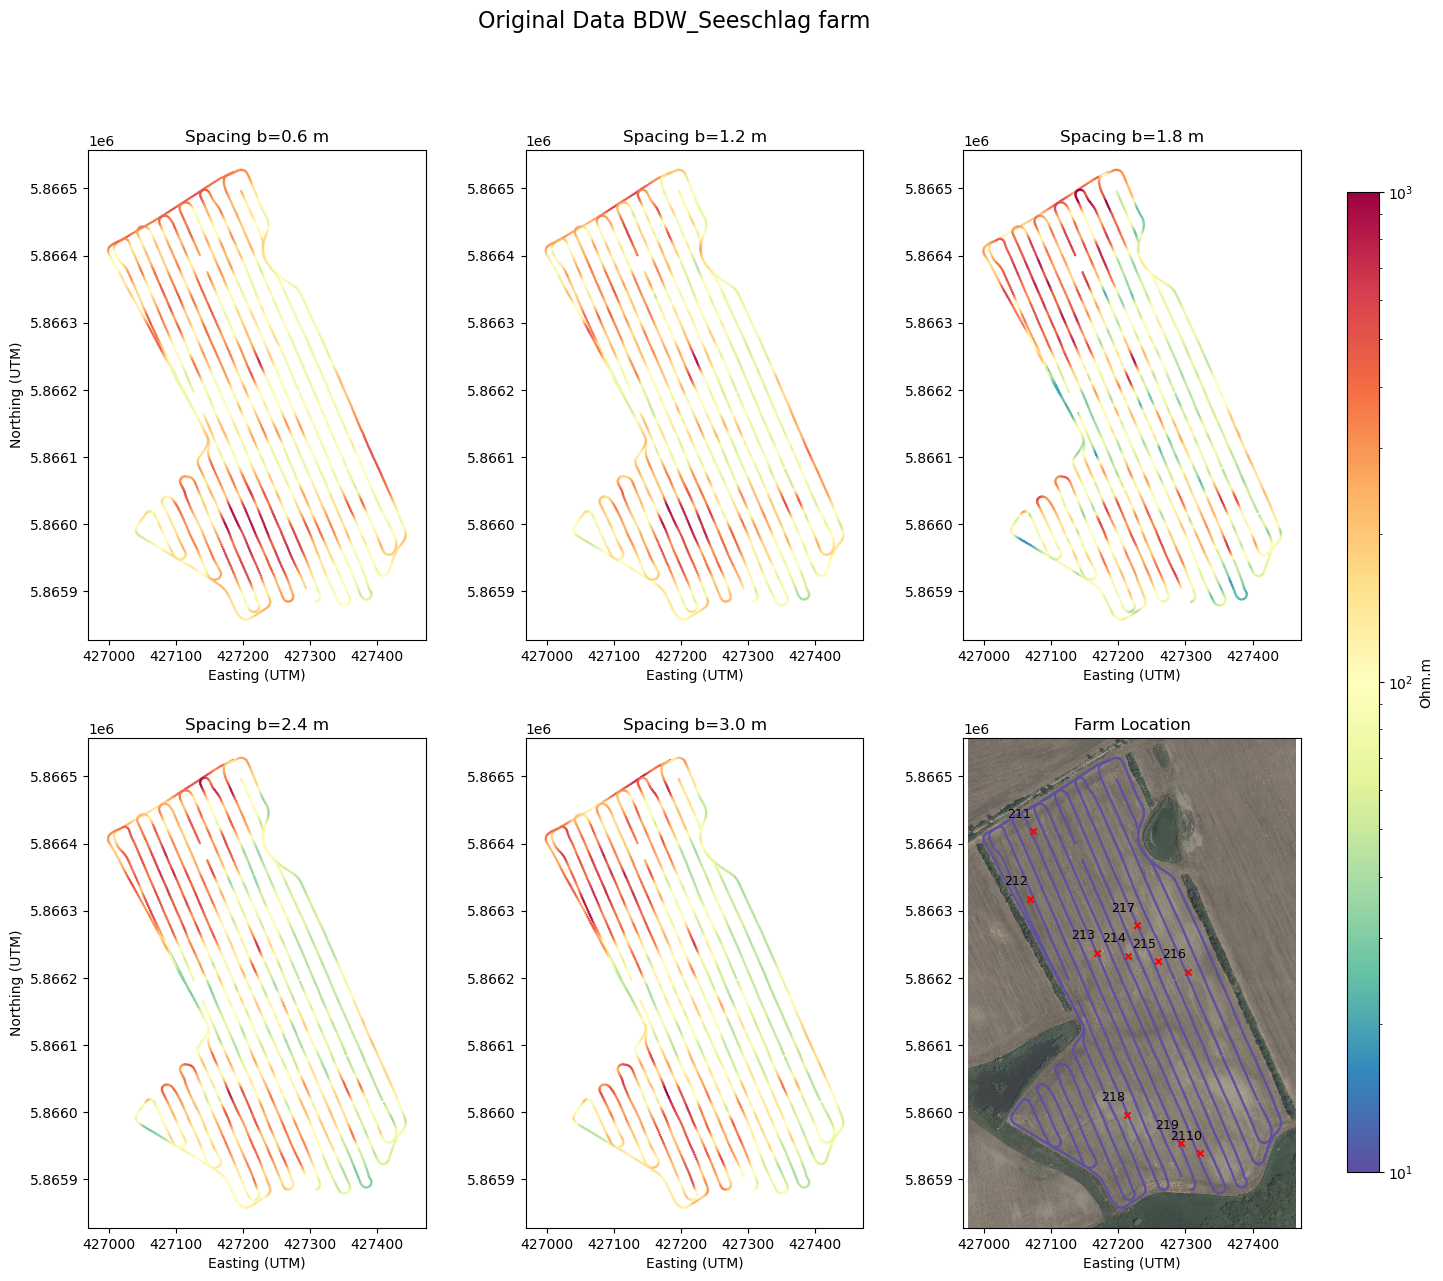

In [10]:
# Plot original data's areal plot
data_type_org = 'Original'
data_org = data_processor.plot_data_subplots(filepath, spacing_labels, farmName, refPoints, data_type_org)

### Local Outlier Factor (LOF) Analysis on Original Data
In this step, we apply the Local Outlier Factor (LOF) method to the original resistivity data to identify potential outliers. 
By applying LOF, we can isolate unusual or potentially erroneous data points, which might represent noise or errors in data collection in the resistivity measurements.

In [13]:
# LOF on Original
data_lineIndexed_file = f"data_lineIndexed_{farmName}.txt"

LOF = data_processor.LOF_outliers(data_lineIndexed_file, spacing_labels, refPoints, farmName)

### Harmfit Analysis on LOF-Detected Data
We are now prepared to apply a curve-fitting method utilizing PyGIMLi, the Harmfit algorithm, to the LOF-detected data. 

This will enable us to achieve a smoother dataset.

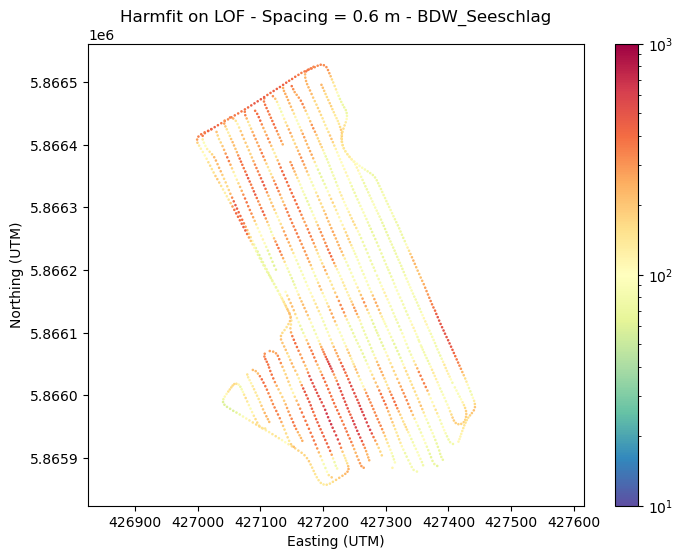

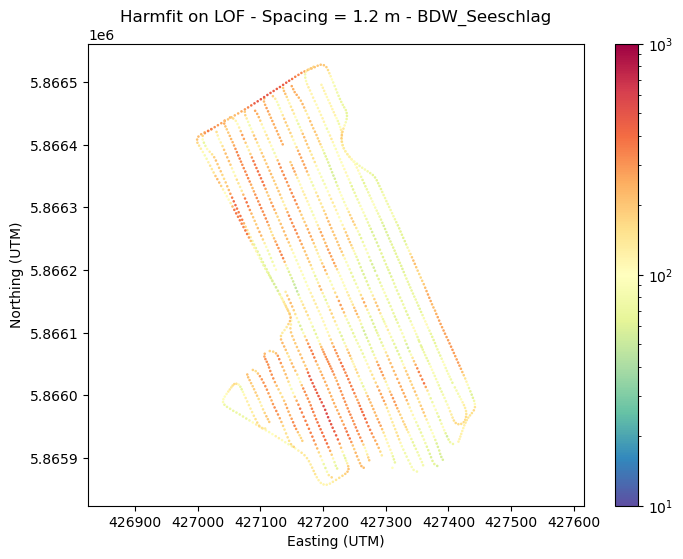

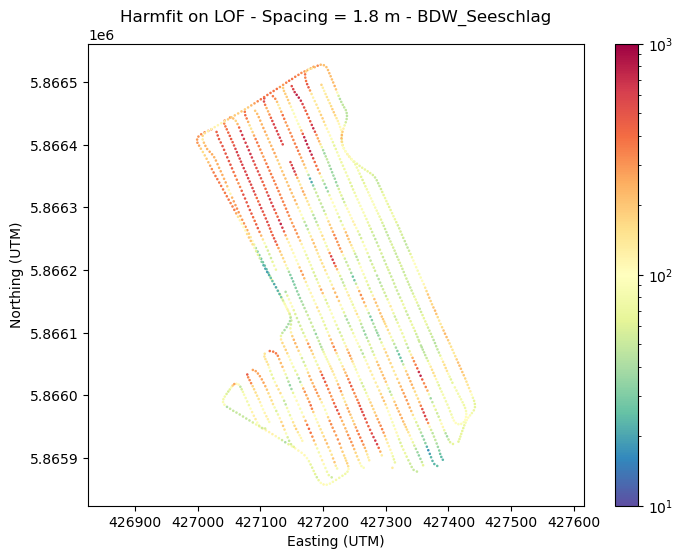

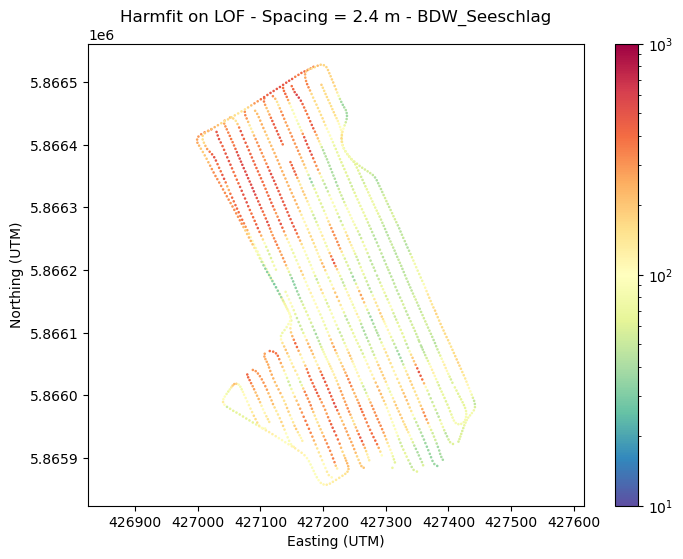

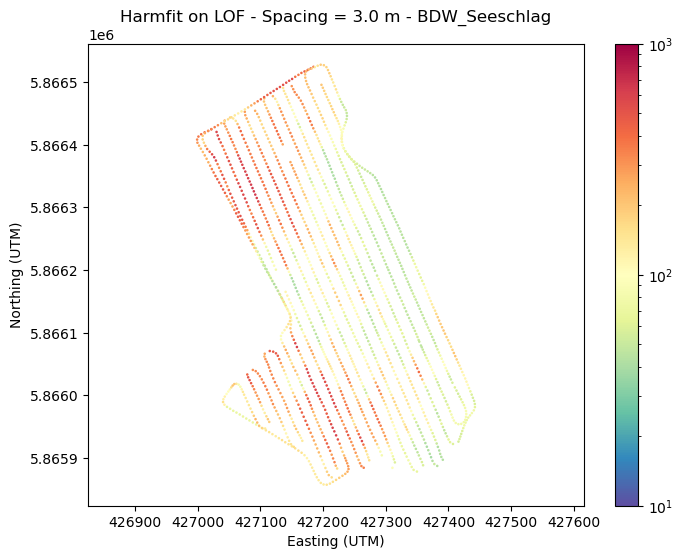

In [16]:
# Harmfit on LOF
LOF_data_file = f"LOF_{farmName}.txt"
data_type_LOF = 'LOF'
harmfit_onLOF = data_processor.harmfit_fn(LOF_data_file, spacing_labels, farmName, refPoints, data_type_LOF)

### Subplot Visualization of Harmfit on LOF-Detected Data
After applying the Harmfit analysis to the LOF-detected outliers, we now visualize the results using subplots. This allows us to compare the smoothed-filtered data across different spatial references.

C:\Users\Roudsari.S\Data_Processing.py:364: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.9, 1])


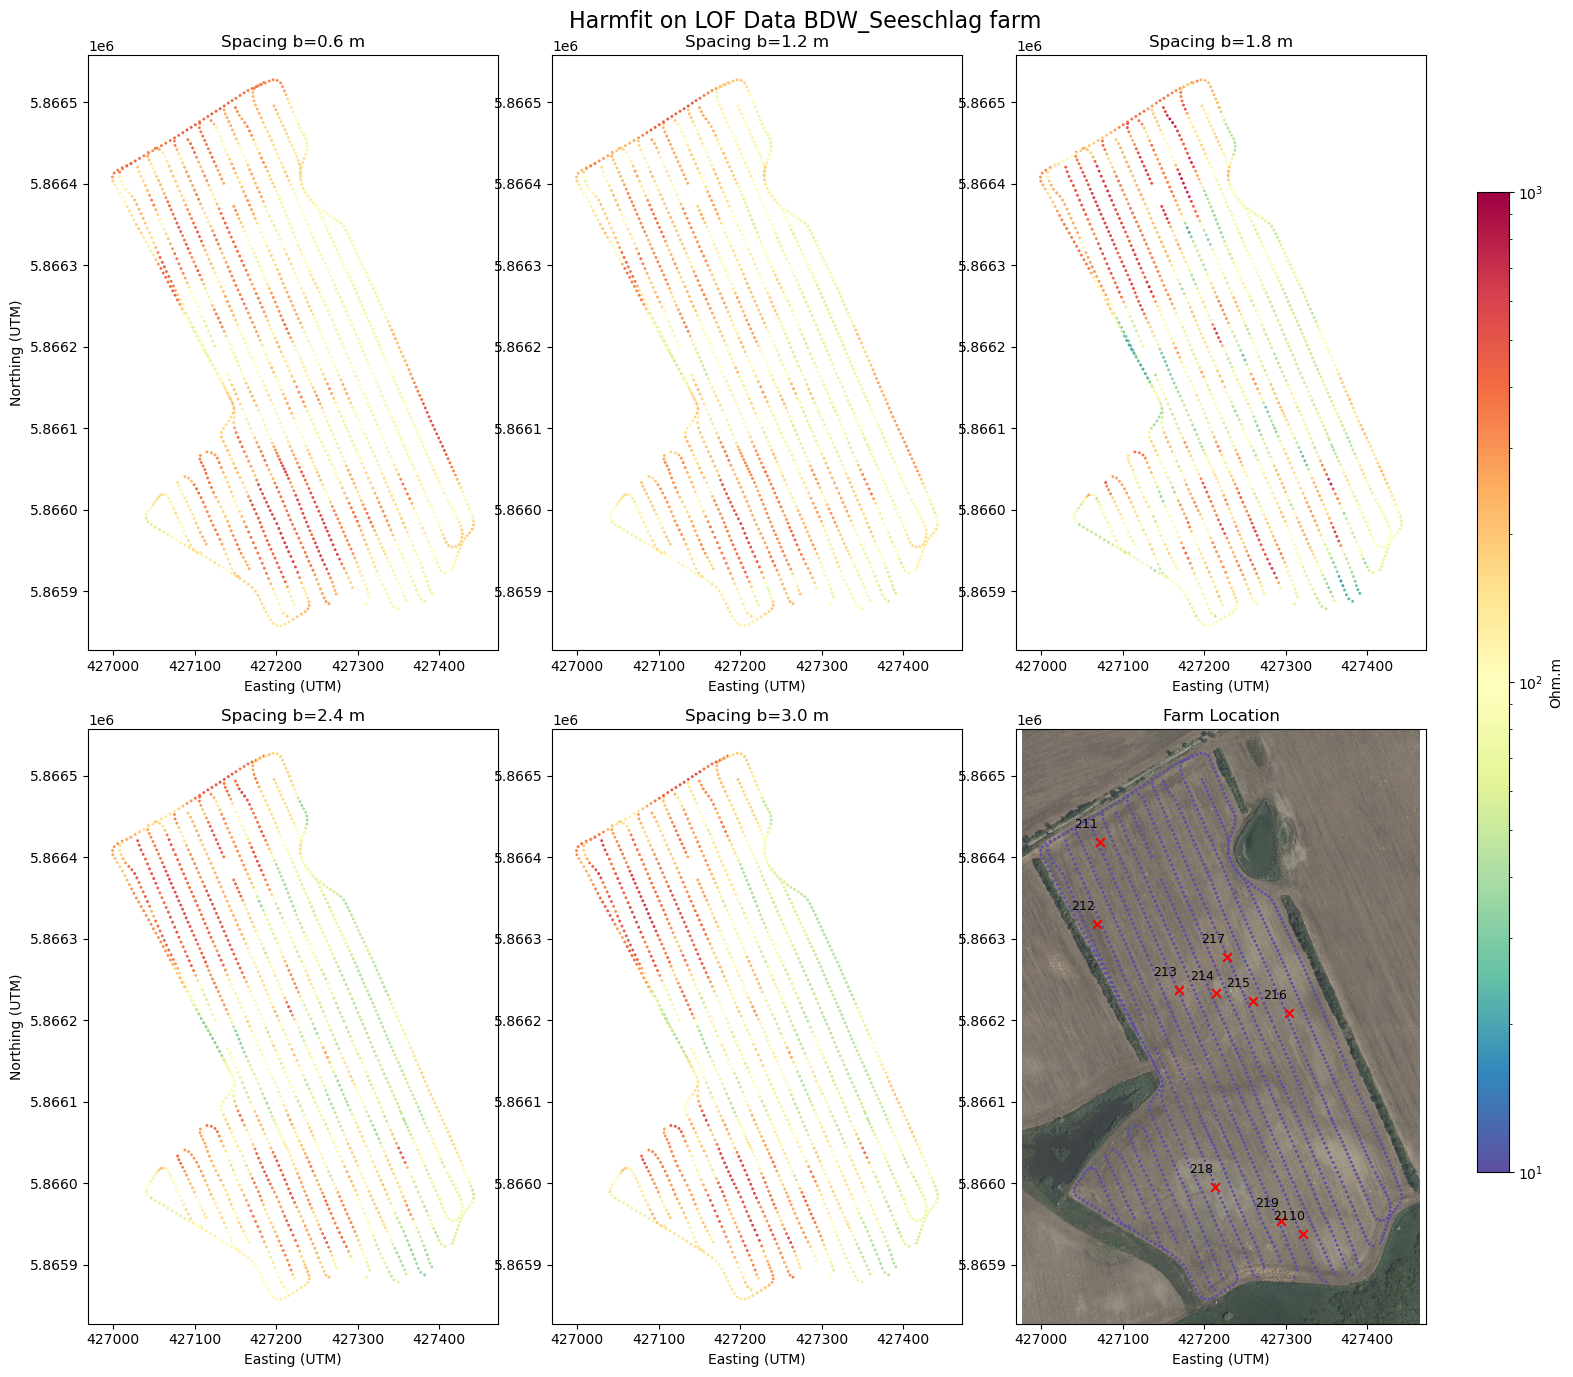

In [18]:
# Subplot plot HLOF
harmfit_onLOF_file = f"harmfitted_{data_type_LOF}_{farmName}.txt"
data_harmfit_LOF = data_processor.plot_procesed_subplots(harmfit_onLOF_file, spacing_labels, farmName, refPoints, data_type_LOF)

### Comparison of Harmfited LOF vs. Original Data
In this step, we compare the Harmfit analysis results applied to the LOF-filtered data with the results from the original resistivity data. This comparison helps in understanding how both smoothing and outlier detection algorithm affect dataset.


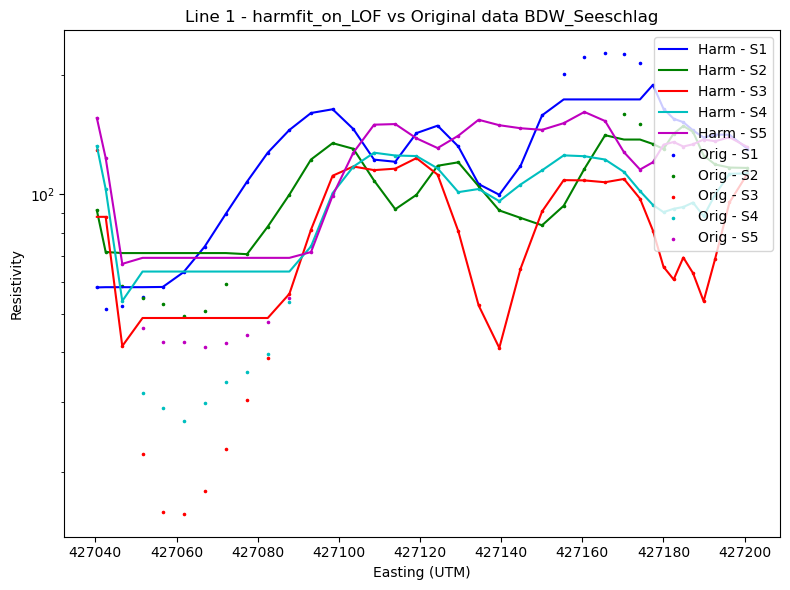

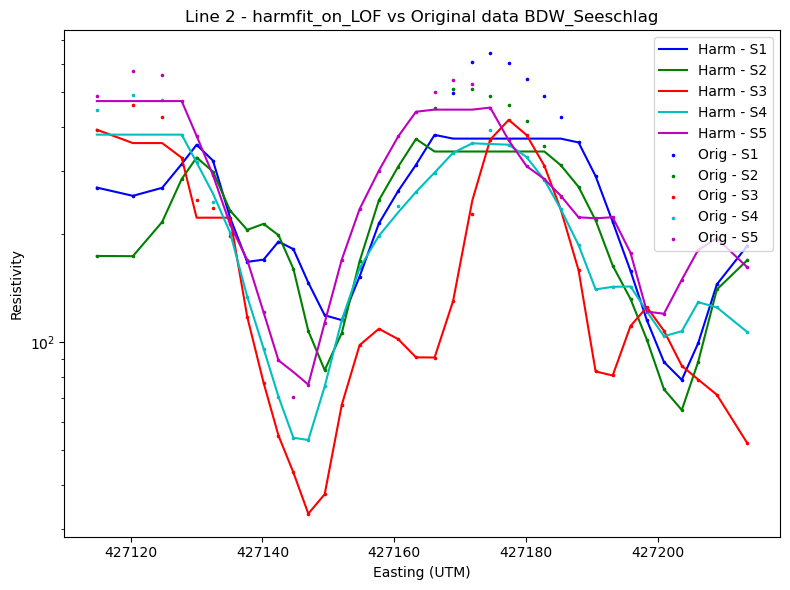

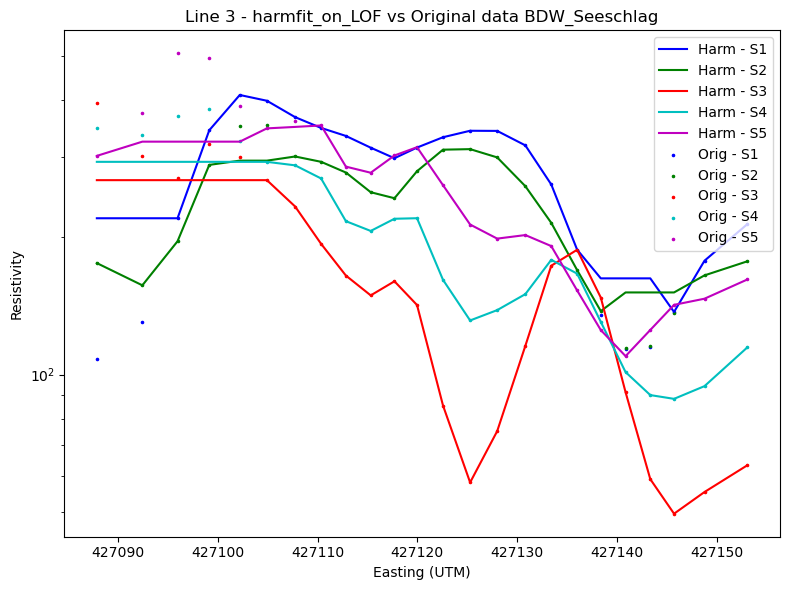

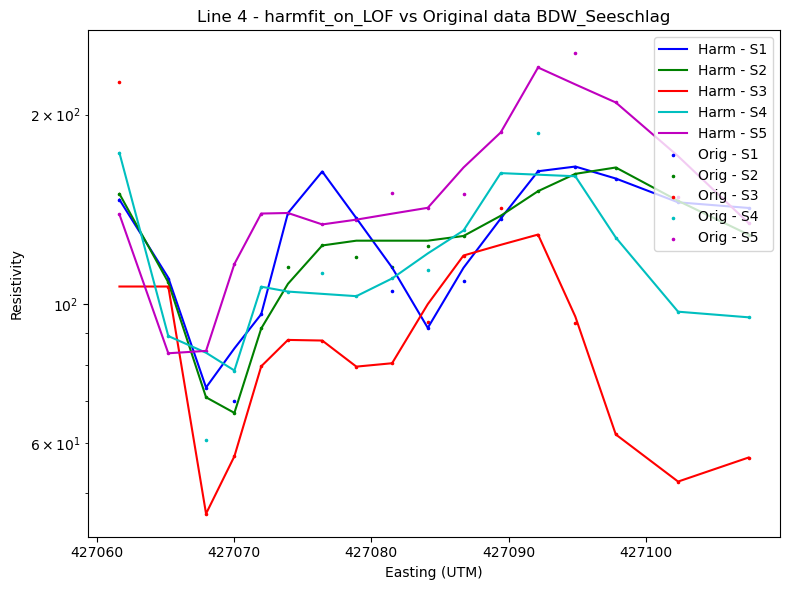

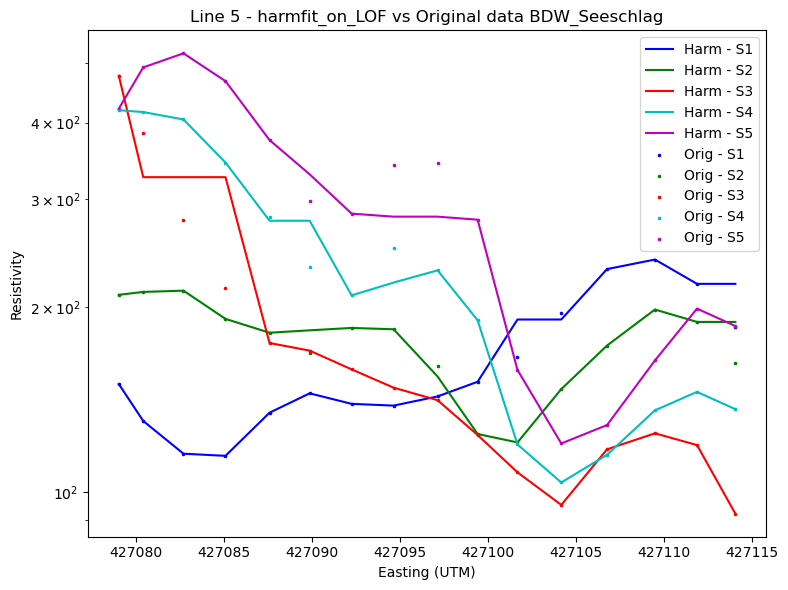

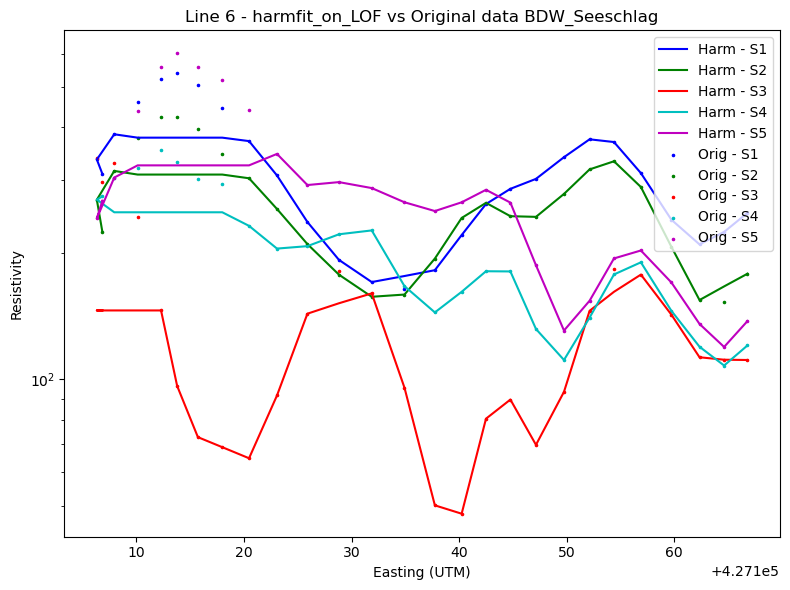

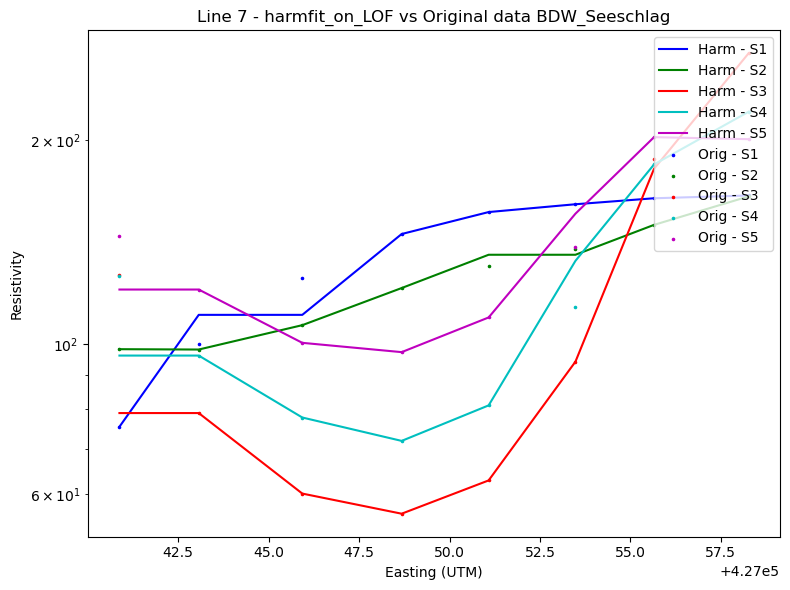

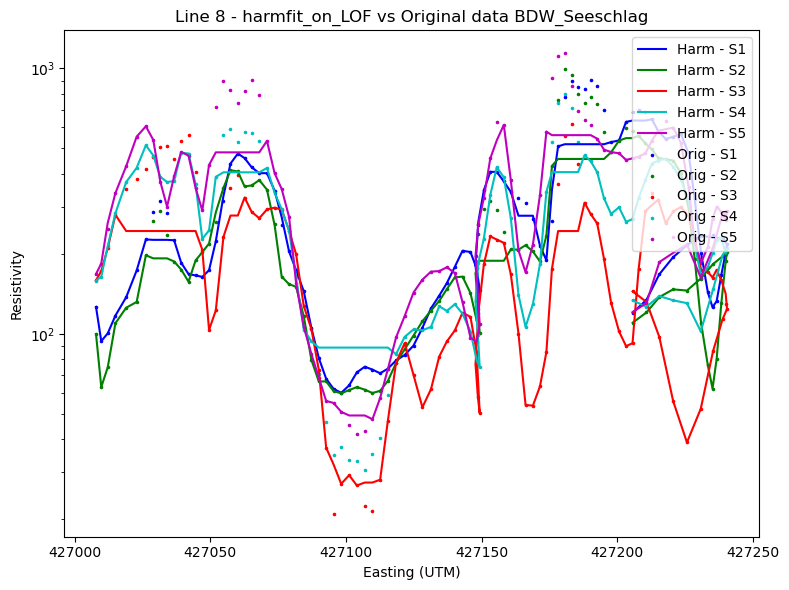

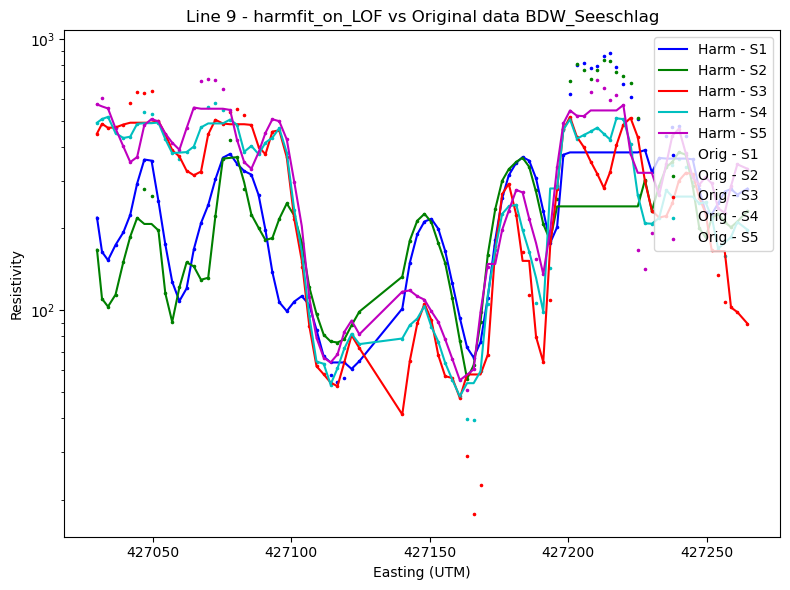

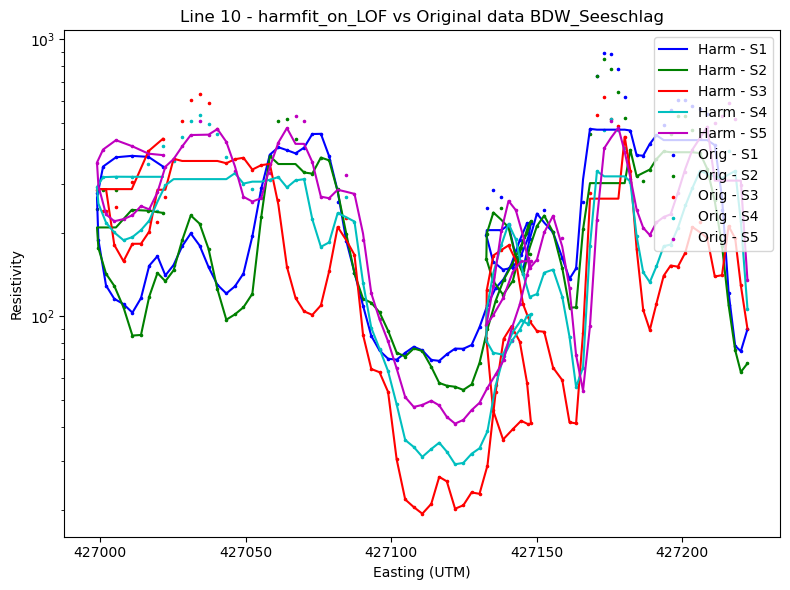

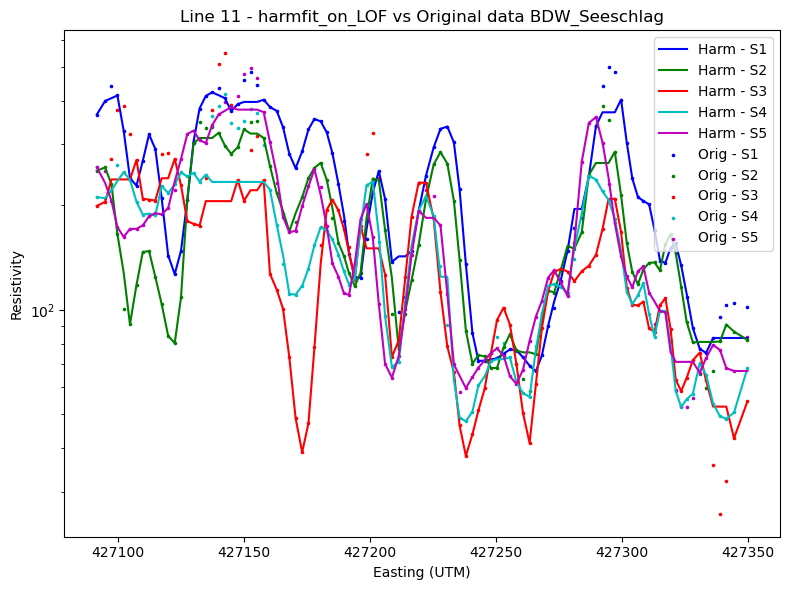

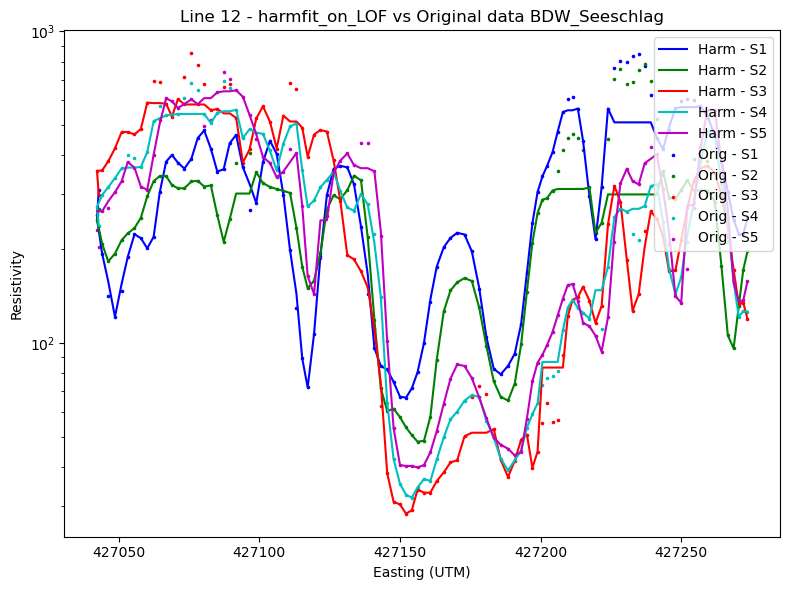

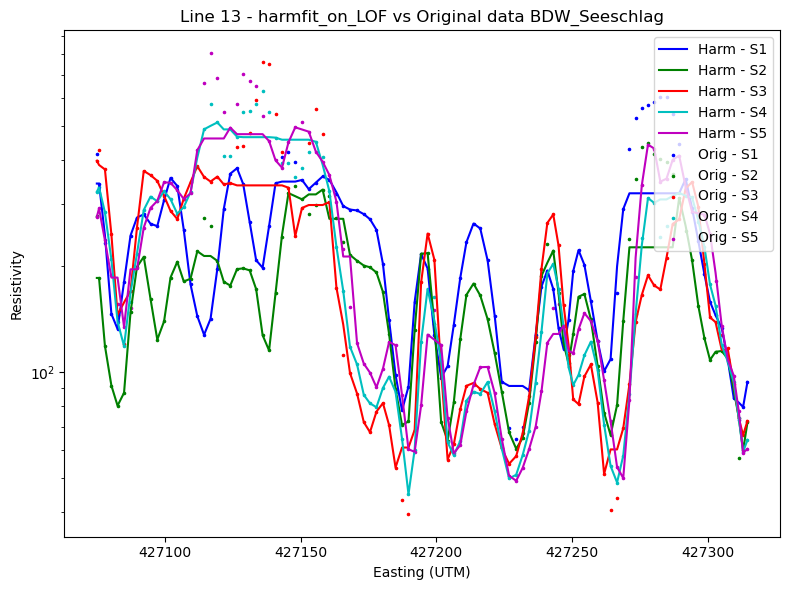

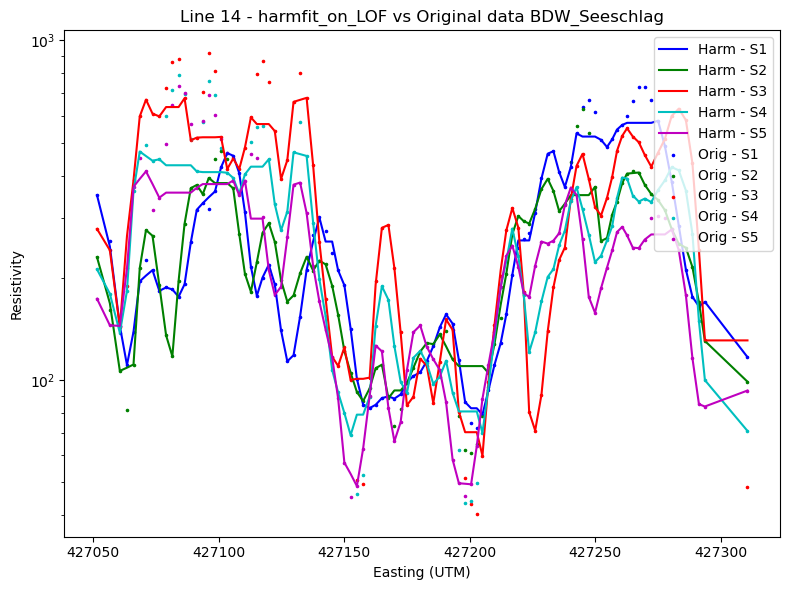

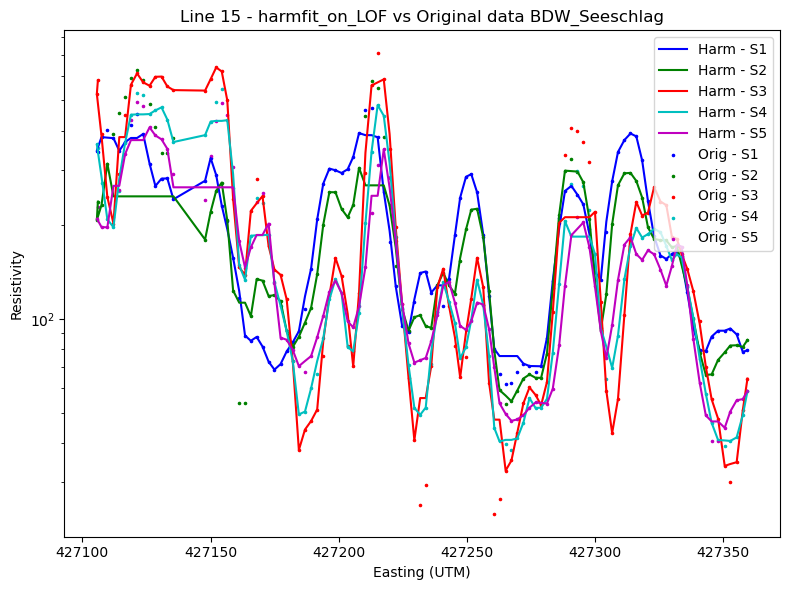

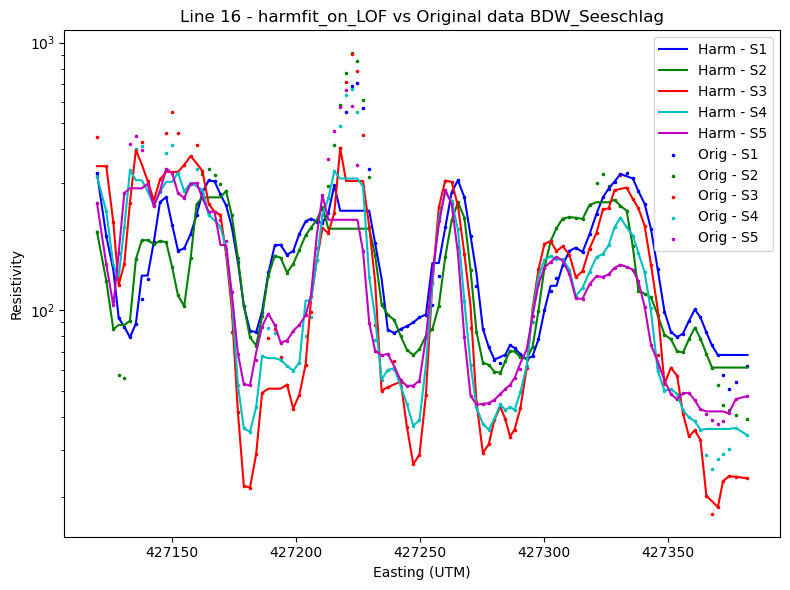

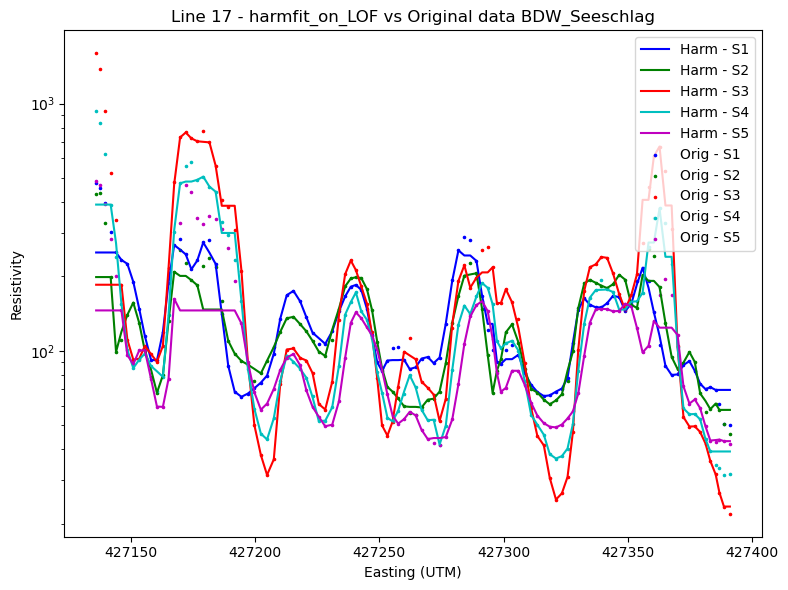

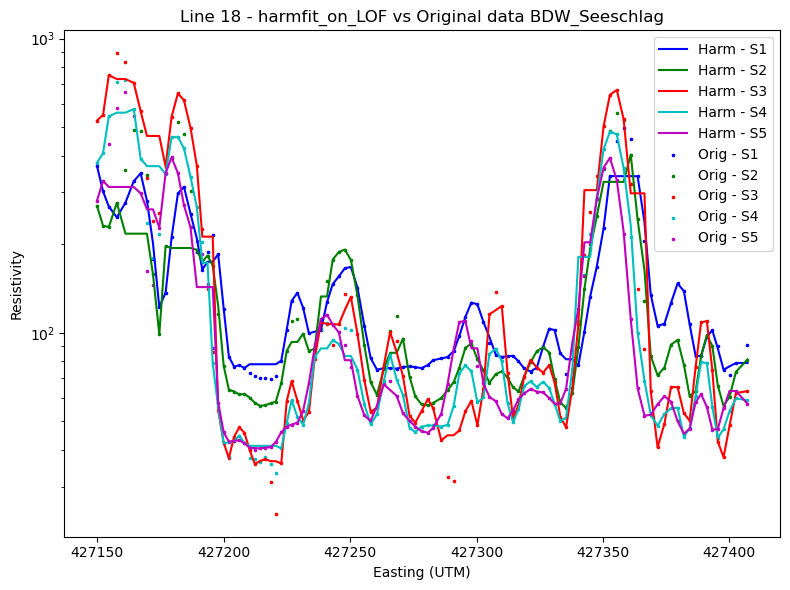

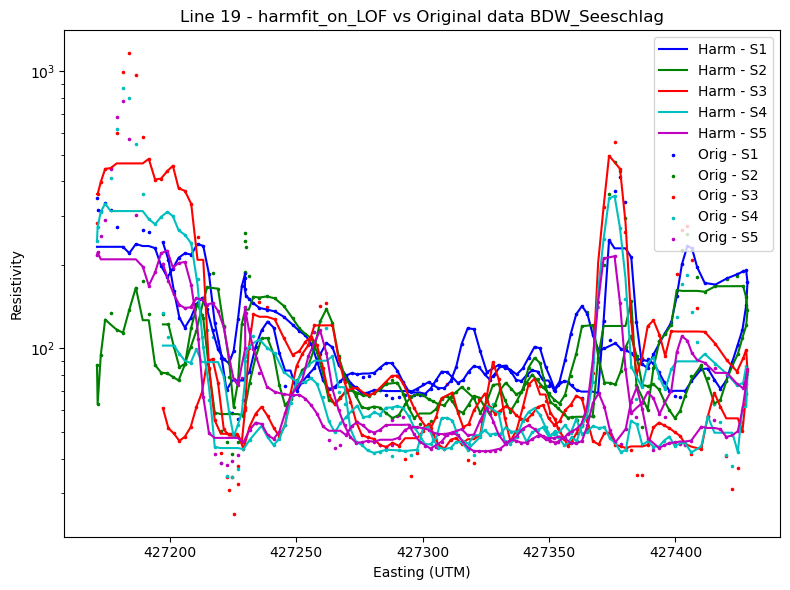

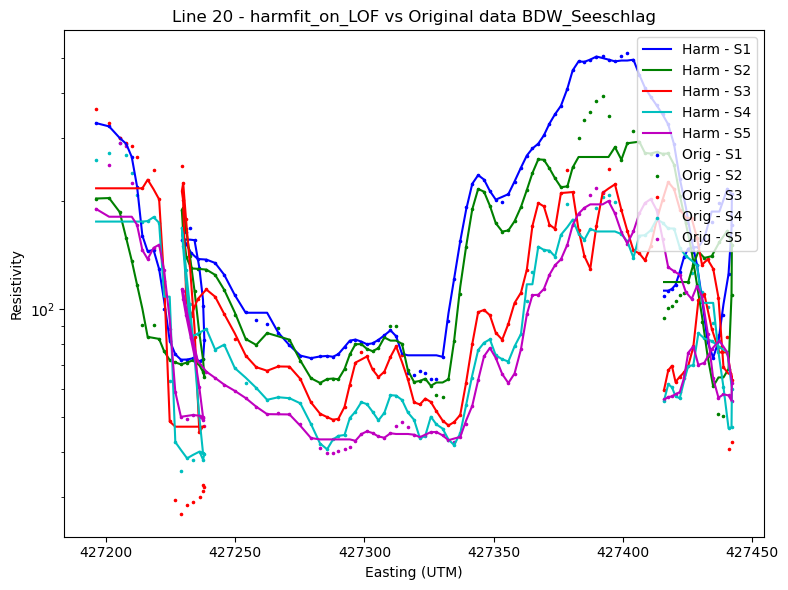

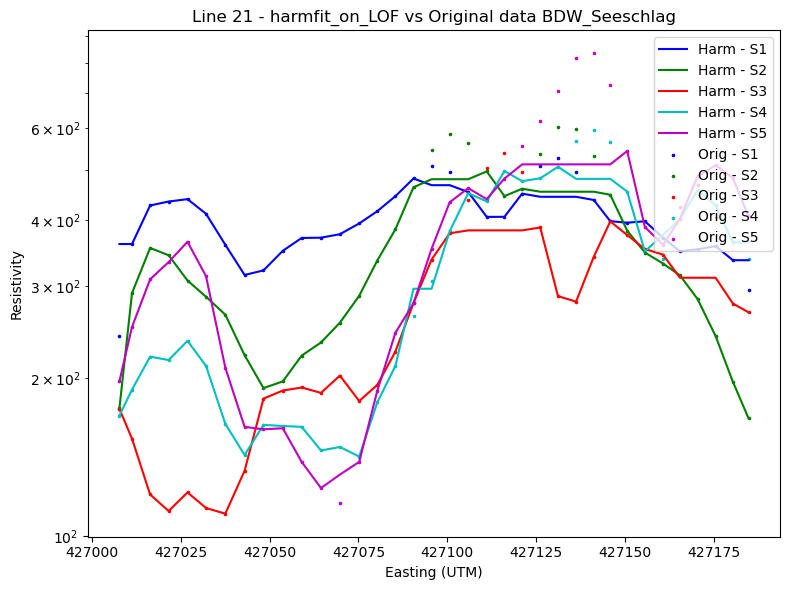

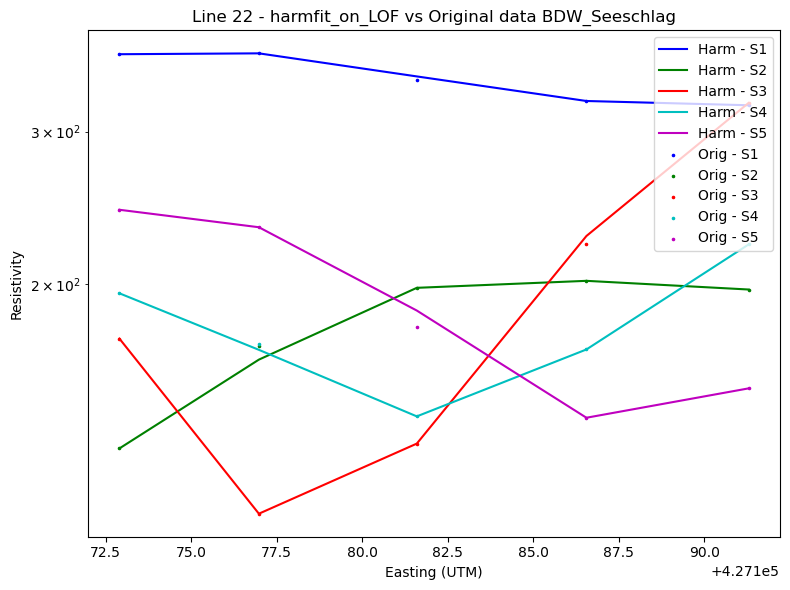

In [19]:
# Define file paths and farm names
# Call the function to compare harmfit on LOF vs original
data_type_LOF = 'LOF'
data_processor.plot_harmfit_vs_original(data_lineIndexed_file, farmName, data_type_LOF)